# Задание 2 (7 баллов)
- Используя код практики или PyTorch, реализовать 3 оптимизатора (например, Nesterov, Adam, RMSProp).
- Реализовать любые 2 шедулера (например, StepLR и ExponentialLR). Проверить реализованное на сгенерированной регрессии.
- Показать графики изменение LR в течение 100 эпох.


## Шаг №0 - Импорт библиотек

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Установка seed для воспроизводимости результатов
np.random.seed(42)
torch.manual_seed(42)

## Шаг №1 - Генерация данных

In [2]:
def generate_regression_data(n_samples=1000, noise=0.3):
    X = np.random.rand(n_samples, 1) * 10
    y_true = 0.5 * X + 2 * np.sin(X) + 1.5
    y = y_true + noise * np.random.randn(n_samples, 1)

    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.FloatTensor(y)

    return X_tensor, y_tensor

## Шаг №2 - Определение модели

In [3]:
class RegressionModel(nn.Module):
    def __init__(self, input_size=1, hidden_sizes=None):
        super(RegressionModel, self).__init__()
        if hidden_sizes is None:
            hidden_sizes = [64, 64, 32]
        layers = [nn.Linear(input_size, hidden_sizes[0]), nn.ReLU()]

        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(hidden_sizes[-1], 1))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

## Шаг №3 - Определение оптимизаторов

In [4]:
class NesterovOptimizer:
    def __init__(self, params, lr=0.01, momentum=0.9):
        self.params = list(params)
        self.lr = lr
        self.momentum = momentum
        self.velocity = [torch.zeros_like(p.data) for p in self.params]

    def step(self):
        for i, p in enumerate(self.params):
            if p.grad is None:
                continue
            self.velocity[i] = self.momentum * self.velocity[i] - self.lr * p.grad
            p.data += self.momentum * self.velocity[i] - self.lr * p.grad

    def zero_grad(self):
        for p in self.params:
            if p.grad is not None:
                p.grad.zero_()


class AdamOptimizer:
    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        self.params = list(params)
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.eps = eps
        self.weight_decay = weight_decay

        self.m = [torch.zeros_like(p) for p in self.params]
        self.v = [torch.zeros_like(p) for p in self.params]
        self.t = 0

    def step(self):
        self.t += 1

        for i, param in enumerate(self.params):
            if param.grad is None:
                continue

            grad = param.grad.data
            if self.weight_decay != 0:
                grad = grad.add(param.data, alpha=self.weight_decay)

            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * grad.pow(2)

            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)

            param.data.addcdiv_(m_hat, v_hat.sqrt().add_(self.eps), value=-self.lr)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()


class RMSPropOptimizer:
    def __init__(self, params, lr=0.01, alpha=0.99, eps=1e-8, weight_decay=0, momentum=0):
        self.params = list(params)
        self.lr = lr
        self.alpha = alpha
        self.eps = eps
        self.weight_decay = weight_decay
        self.momentum = momentum

        self.square_avg = [torch.zeros_like(p) for p in self.params]
        self.buf = [torch.zeros_like(p) for p in self.params] if momentum > 0 else None

    def step(self):
        for i, param in enumerate(self.params):
            if param.grad is None:
                continue

            grad = param.grad.data
            if self.weight_decay != 0:
                grad = grad.add(param.data, alpha=self.weight_decay)

            self.square_avg[i] = self.alpha * self.square_avg[i] + (1 - self.alpha) * grad.pow(2)

            avg = self.square_avg[i].sqrt().add_(self.eps)

            if self.momentum > 0:
                self.buf[i] = self.momentum * self.buf[i] + grad / avg
                param.data.add_(self.buf[i], alpha=-self.lr)
            else:
                param.data.addcdiv_(grad, avg, value=-self.lr)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

## Шаг №4 - Определение шедулеров

In [5]:
class StepLR:
    def __init__(self, optimizer, step_size, gamma=0.1):
        self.optimizer = optimizer
        self.step_size = step_size
        self.gamma = gamma
        self.current_epoch = 0
        self.initial_lr = optimizer.lr
        self.lr_history = [optimizer.lr]

    def step(self):
        self.current_epoch += 1
        if self.current_epoch % self.step_size == 0:
            self.optimizer.lr = self.optimizer.lr * self.gamma

        self.lr_history.append(self.optimizer.lr)
        return self.optimizer.lr


class ExponentialLR:
    def __init__(self, optimizer, gamma=0.9):
        self.optimizer = optimizer
        self.gamma = gamma
        self.current_epoch = 0
        self.initial_lr = optimizer.lr
        self.lr_history = [optimizer.lr]

    def step(self):
        self.current_epoch += 1
        self.optimizer.lr = self.initial_lr * (self.gamma ** self.current_epoch)

        self.lr_history.append(self.optimizer.lr)
        return self.optimizer.lr

## Шаг №5 - Обучение модели

In [6]:
def train_model(model, X, y, optimizer, scheduler=None, epochs=100, batch_size=32):
    criterion = nn.MSELoss()
    loss_history = []

    dataset = torch.utils.data.TensorDataset(X, y)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        total_loss = 0
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            y_pred = model(batch_X)
            loss = criterion(y_pred, batch_y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        if scheduler:
            scheduler.step()

        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.6f}, LR: {optimizer.lr:.6f}")

    return loss_history


## Шаг №6 - Эксперименты

In [7]:
def run_experiment():
    experiments = []

    epochs = 100

    X, y = generate_regression_data(n_samples=1000, noise=0.3)

    plt.figure(figsize=(10, 6))
    plt.scatter(X.numpy(), y.numpy(), s=5, alpha=0.3)
    plt.title('Исходные данные для регрессии')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.grid(True, alpha=0.3)
    plt.savefig('original_data.png')
    plt.show()

    print("\n--- Эксперимент 1: Nesterov с StepLR ---")
    model1 = RegressionModel()
    optimizer1 = NesterovOptimizer(model1.parameters(), lr=0.001, momentum=0.95)
    scheduler1 = StepLR(optimizer1, step_size=20, gamma=0.5)
    loss_history1 = train_model(model1, X, y, optimizer1, scheduler1, epochs=epochs)

    experiments.append({
        'title': 'Nesterov с StepLR',
        'model': model1,
        'loss_history': loss_history1,
        'lr_history': scheduler1.lr_history,
        'color': 'blue',
        'linestyle': '-'
    })

    print("\n--- Эксперимент 2: Adam с StepLR ---")
    model2 = RegressionModel()
    optimizer2 = AdamOptimizer(model2.parameters(), lr=0.01)
    scheduler2 = StepLR(optimizer2, step_size=20, gamma=0.5)
    loss_history2 = train_model(model2, X, y, optimizer2, scheduler2, epochs=epochs)

    experiments.append({
        'title': 'Adam с StepLR',
        'model': model2,
        'loss_history': loss_history2,
        'lr_history': scheduler2.lr_history,
        'color': 'orange',
        'linestyle': '-'
    })

    print("\n--- Эксперимент 3: RMSProp с StepLR ---")
    model3 = RegressionModel()
    optimizer3 = RMSPropOptimizer(model3.parameters(), lr=0.01, alpha=0.9)
    scheduler3 = StepLR(optimizer3, step_size=20, gamma=0.5)
    loss_history3 = train_model(model3, X, y, optimizer3, scheduler3, epochs=epochs)

    experiments.append({
        'title': 'RMSProp с StepLR',
        'model': model3,
        'loss_history': loss_history3,
        'lr_history': scheduler3.lr_history,
        'color': 'green',
        'linestyle': '-'
    })

    print("\n--- Эксперимент 4: Nesterov с ExponentialLR ---")
    model4 = RegressionModel()
    optimizer4 = NesterovOptimizer(model4.parameters(), lr=0.02, momentum=0.9)
    scheduler4 = ExponentialLR(optimizer4, gamma=0.97)
    loss_history4 = train_model(model4, X, y, optimizer4, scheduler4, epochs=epochs)

    experiments.append({
        'title': 'Nesterov с ExponentialLR',
        'model': model4,
        'loss_history': loss_history4,
        'lr_history': scheduler4.lr_history,
        'color': 'red',
        'linestyle': '-'
    })

    print("\n--- Эксперимент 5: Adam с ExponentialLR ---")
    model5 = RegressionModel()
    optimizer5 = AdamOptimizer(model5.parameters(), lr=0.01)
    scheduler5 = ExponentialLR(optimizer5, gamma=0.97)
    loss_history5 = train_model(model5, X, y, optimizer5, scheduler5, epochs=epochs)

    experiments.append({
        'title': 'Adam с ExponentialLR',
        'model': model5,
        'loss_history': loss_history5,
        'lr_history': scheduler5.lr_history,
        'color': 'purple',
        'linestyle': '-'
    })

    print("\n--- Эксперимент 6: RMSProp с ExponentialLR ---")
    model6 = RegressionModel()
    optimizer6 = RMSPropOptimizer(model6.parameters(), lr=0.01, alpha=0.99)
    scheduler6 = ExponentialLR(optimizer6, gamma=0.97)
    loss_history6 = train_model(model6, X, y, optimizer6, scheduler6, epochs=epochs)

    experiments.append({
        'title': 'RMSProp с ExponentialLR',
        'model': model6,
        'loss_history': loss_history6,
        'lr_history': scheduler6.lr_history,
        'color': 'brown',
        'linestyle': '-'
    })

    return experiments, X, y

## Шаг №7 - Визуализация результатов

In [8]:
def visualize_all_results(experiments, X, y):
    # 1. Визуализация изменения скорости обучения для оптимизаторов с StepLR
    plt.figure(figsize=(14, 12))

    step_lr_exps = [exp for exp in experiments if 'StepLR' in exp['title']]
    exp_lr_exps = [exp for exp in experiments if 'ExponentialLR' in exp['title']]

    plt.subplot(2, 1, 1)
    for exp in step_lr_exps:
        plt.plot(range(len(exp['lr_history'])), exp['lr_history'],
                 label=exp['title'], color=exp['color'], linestyle=exp['linestyle'], linewidth=2)
    plt.title('Изменение скорости обучения с StepLR', fontsize=14)
    plt.xlabel('Эпоха', fontsize=12)
    plt.ylabel('Learning Rate', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)

    plt.subplot(2, 1, 2)
    for exp in exp_lr_exps:
        plt.plot(range(len(exp['lr_history'])), exp['lr_history'],
                 label=exp['title'], color=exp['color'], linestyle=exp['linestyle'], linewidth=2)
    plt.title('Изменение скорости обучения с ExponentialLR', fontsize=14)
    plt.xlabel('Эпоха', fontsize=12)
    plt.ylabel('Learning Rate', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)

    plt.tight_layout()
    plt.savefig('lr_changes.png', dpi=300)
    plt.show()

    # 2. Визуализация истории потерь
    plt.figure(figsize=(14, 8))
    for exp in experiments:
        plt.plot(exp['loss_history'], label=exp['title'], color=exp['color'],
                 linestyle=exp['linestyle'], linewidth=2)
    plt.title('История потерь для всех экспериментов', fontsize=14)
    plt.xlabel('Эпоха', fontsize=12)
    plt.ylabel('Потери (MSE)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    plt.yscale('log')
    plt.savefig('loss_history.png', dpi=300)
    plt.show()

    # 3. Визуализация результатов регрессии
    plt.figure(figsize=(15, 10))
    for i, exp in enumerate(experiments):
        plt.subplot(2, 3, i + 1)

        sorted_indices = torch.argsort(X.view(-1))
        X_sorted = X[sorted_indices]
        y_sorted = y[sorted_indices]

        with torch.no_grad():
            y_pred = exp['model'](X_sorted)

        X_np = X_sorted.numpy()
        y_np = y_sorted.numpy()
        y_pred_np = y_pred.numpy()

        plt.scatter(X_np, y_np, s=5, alpha=0.1, label='Исходные данные', color='lightblue')
        plt.plot(X_np, y_pred_np, 'r-', linewidth=2, label='Предсказание')
        plt.title(exp['title'], fontsize=12)
        plt.xlabel('X', fontsize=10)
        plt.ylabel('y', fontsize=10)
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('regression_results.png', dpi=300)
    plt.show()


def visualize_lr_detailed():
    epochs = 100

    model_step = RegressionModel()
    optimizer_step = NesterovOptimizer(model_step.parameters(), lr=0.01)
    scheduler_step = StepLR(optimizer_step, step_size=20, gamma=0.5)

    model_exp = RegressionModel()
    optimizer_exp = NesterovOptimizer(model_exp.parameters(), lr=0.01)
    scheduler_exp = ExponentialLR(optimizer_exp, gamma=0.97)

    step_lr_history = [optimizer_step.lr]
    exp_lr_history = [optimizer_exp.lr]

    for epoch in range(epochs):
        scheduler_step.step()
        scheduler_exp.step()
        step_lr_history.append(optimizer_step.lr)
        exp_lr_history.append(optimizer_exp.lr)

    plt.figure(figsize=(15, 8))

    # График в обычном масштабе
    plt.subplot(1, 2, 1)
    plt.plot(step_lr_history, label='StepLR (step=20, gamma=0.5)', color='blue', linewidth=2)
    plt.plot(exp_lr_history, label='ExponentialLR (gamma=0.97)', color='orange', linewidth=2)
    plt.title('Изменение LR в течение 100 эпох', fontsize=14)
    plt.xlabel('Эпоха', fontsize=12)
    plt.ylabel('Learning Rate', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)

    # График в логарифмическом масштабе
    plt.subplot(1, 2, 2)
    plt.plot(step_lr_history, label='StepLR (step=20, gamma=0.5)', color='blue', linewidth=2)
    plt.plot(exp_lr_history, label='ExponentialLR (gamma=0.97)', color='orange', linewidth=2)
    plt.title('Изменение LR в течение 100 эпох (log scale)', fontsize=14)
    plt.xlabel('Эпоха', fontsize=12)
    plt.ylabel('Learning Rate', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    plt.legend(fontsize=10)

    plt.tight_layout()
    plt.savefig('lr_comparison_detailed.png', dpi=300)
    plt.show()

## Шаг №8 - Запуск экспериментов и визуализация результатов

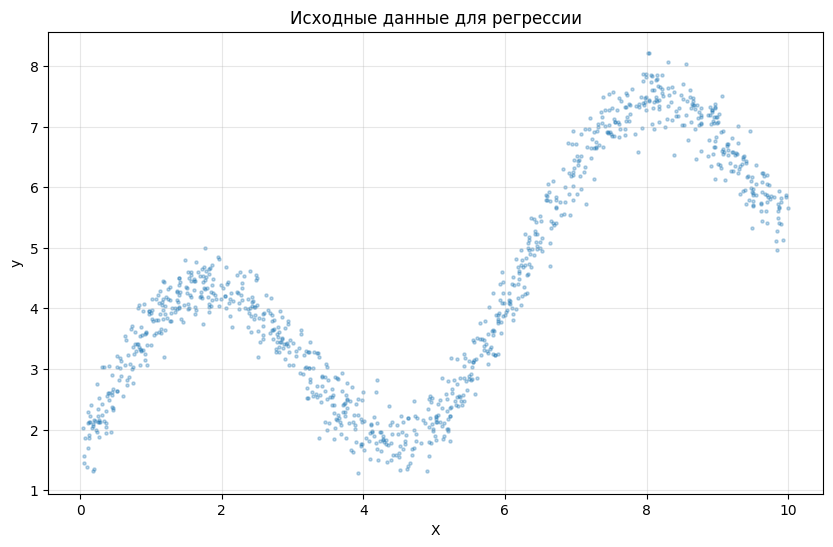


--- Эксперимент 1: Nesterov с StepLR ---
Epoch 10/100, Loss: 0.835986, LR: 0.001000
Epoch 20/100, Loss: 0.780177, LR: 0.000500
Epoch 30/100, Loss: 0.683795, LR: 0.000500
Epoch 40/100, Loss: 0.549113, LR: 0.000250
Epoch 50/100, Loss: 0.462705, LR: 0.000250
Epoch 60/100, Loss: 0.379887, LR: 0.000125
Epoch 70/100, Loss: 0.305970, LR: 0.000125
Epoch 80/100, Loss: 0.258218, LR: 0.000063
Epoch 90/100, Loss: 0.238688, LR: 0.000063
Epoch 100/100, Loss: 0.212037, LR: 0.000031

--- Эксперимент 2: Adam с StepLR ---
Epoch 10/100, Loss: 0.794494, LR: 0.010000
Epoch 20/100, Loss: 0.795156, LR: 0.005000
Epoch 30/100, Loss: 0.612512, LR: 0.005000
Epoch 40/100, Loss: 0.419451, LR: 0.002500
Epoch 50/100, Loss: 0.153027, LR: 0.002500
Epoch 60/100, Loss: 0.130757, LR: 0.001250
Epoch 70/100, Loss: 0.093634, LR: 0.001250
Epoch 80/100, Loss: 0.090520, LR: 0.000625
Epoch 90/100, Loss: 0.092079, LR: 0.000625
Epoch 100/100, Loss: 0.090120, LR: 0.000313

--- Эксперимент 3: RMSProp с StepLR ---
Epoch 10/100, Los

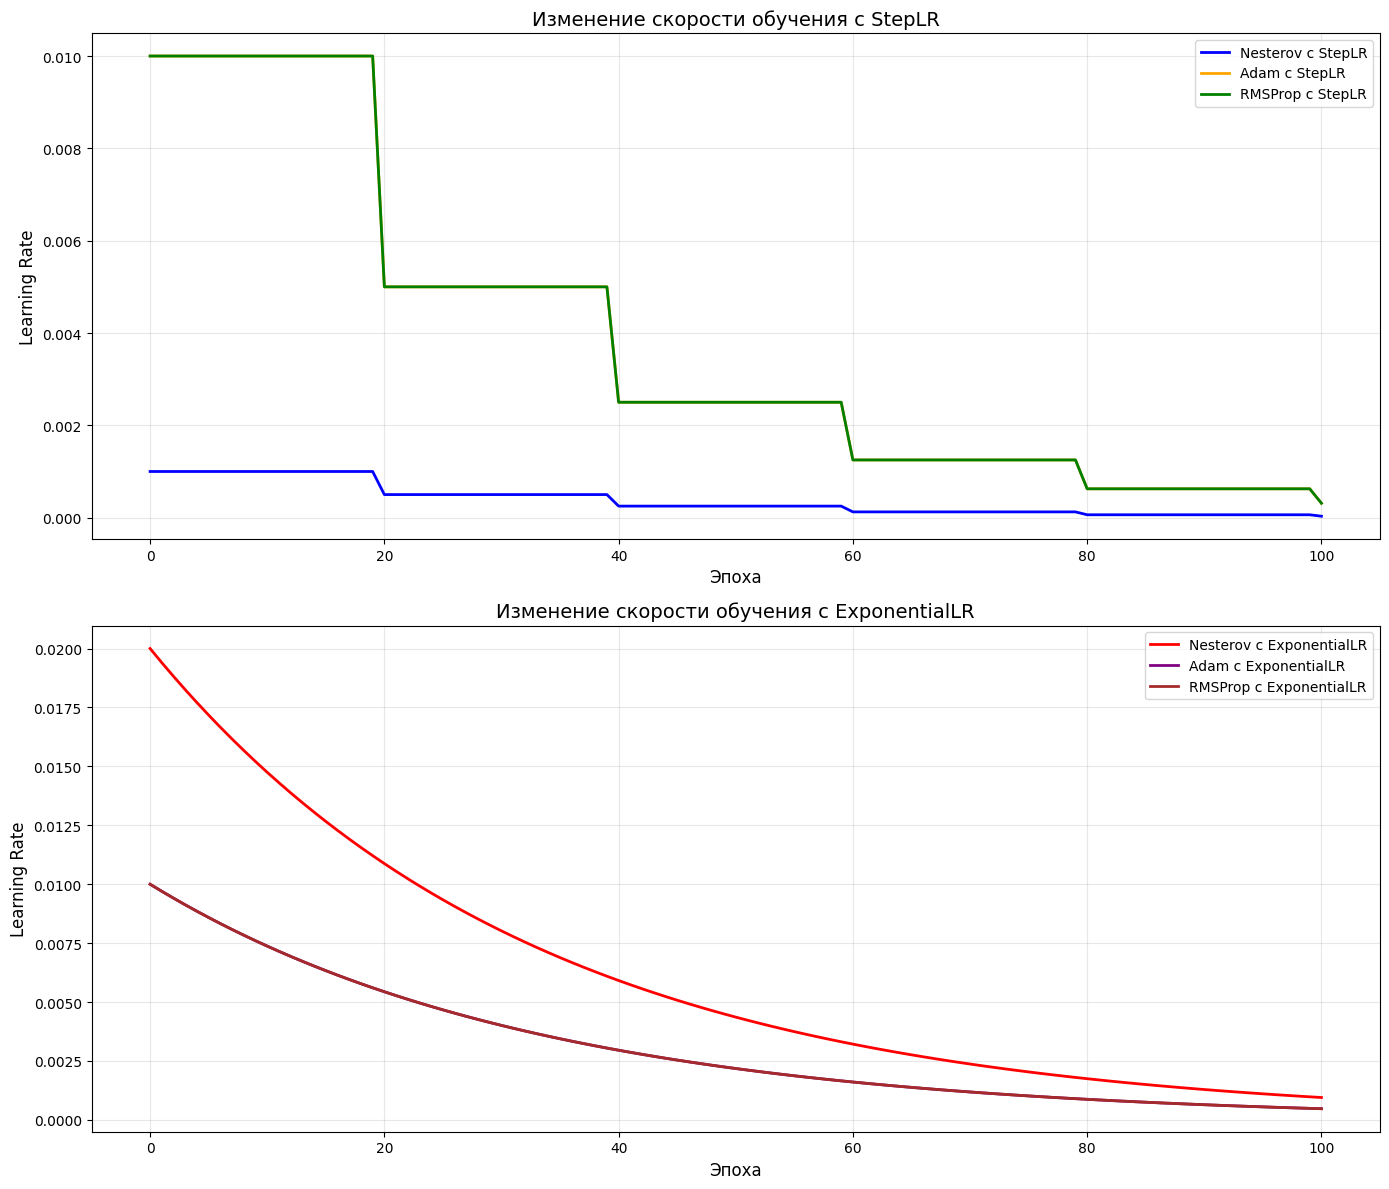

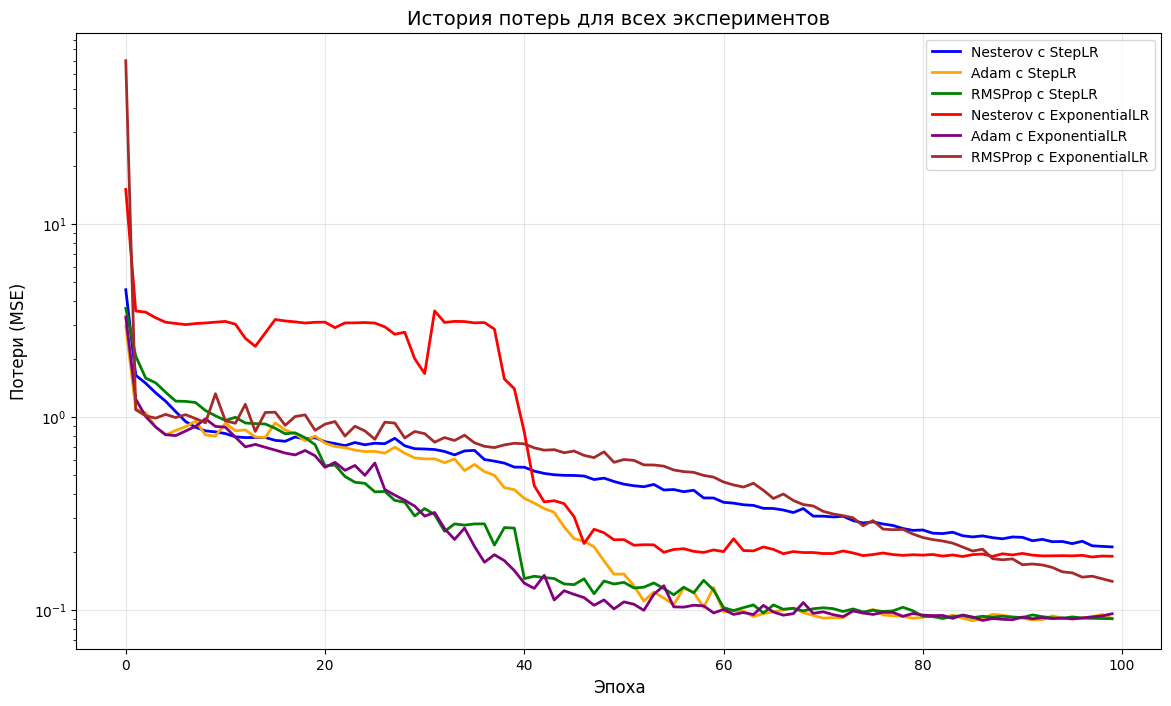

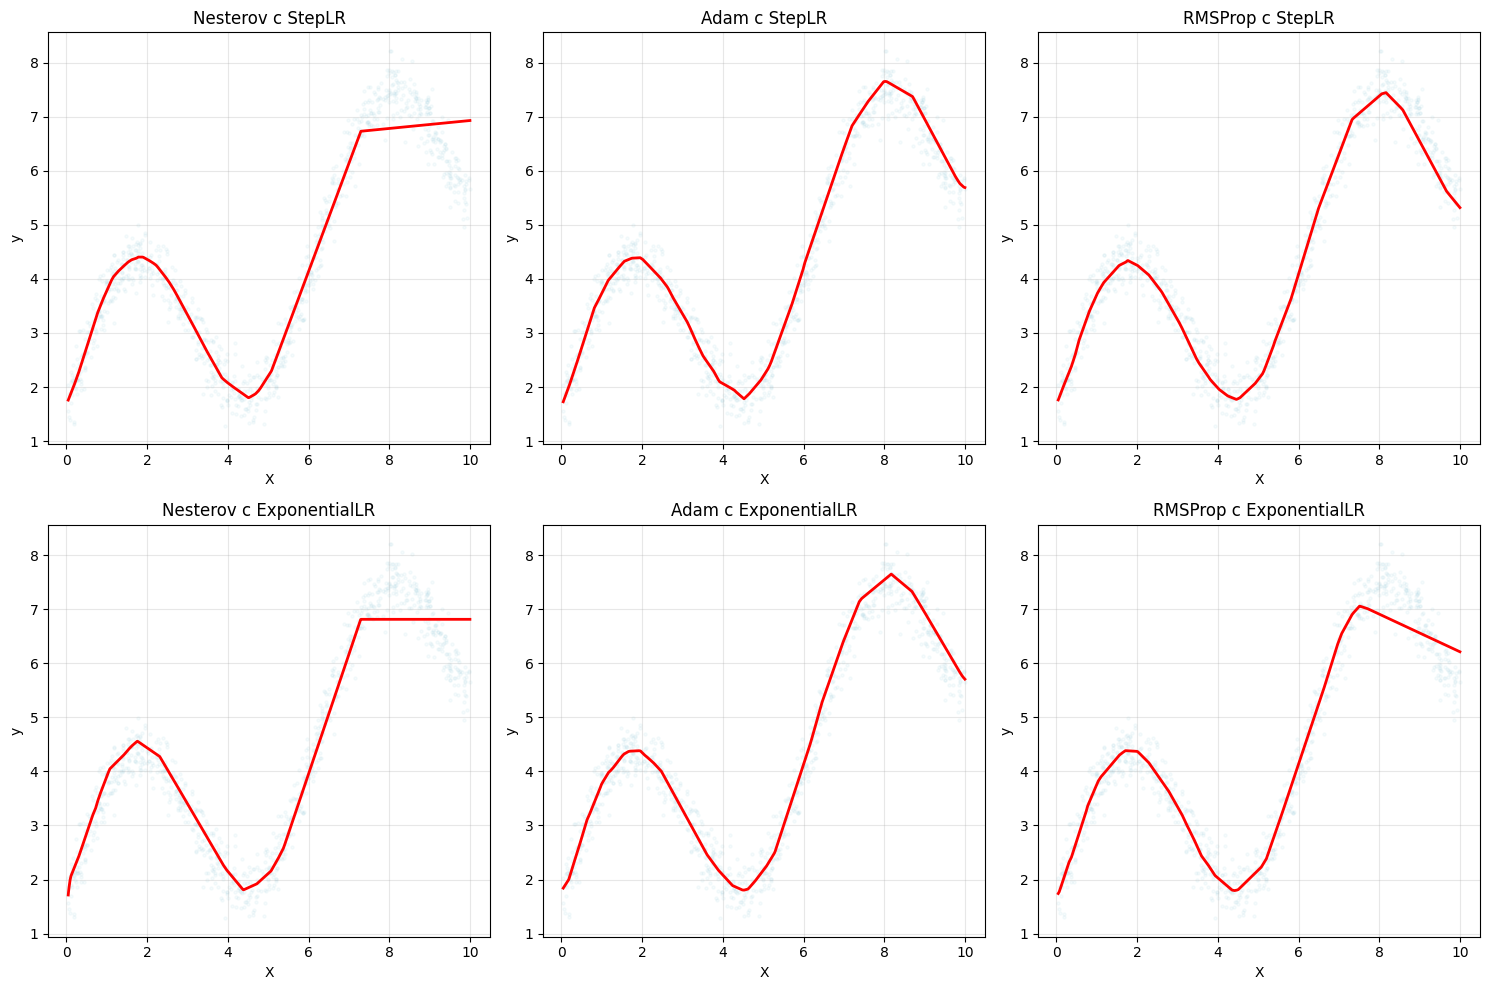

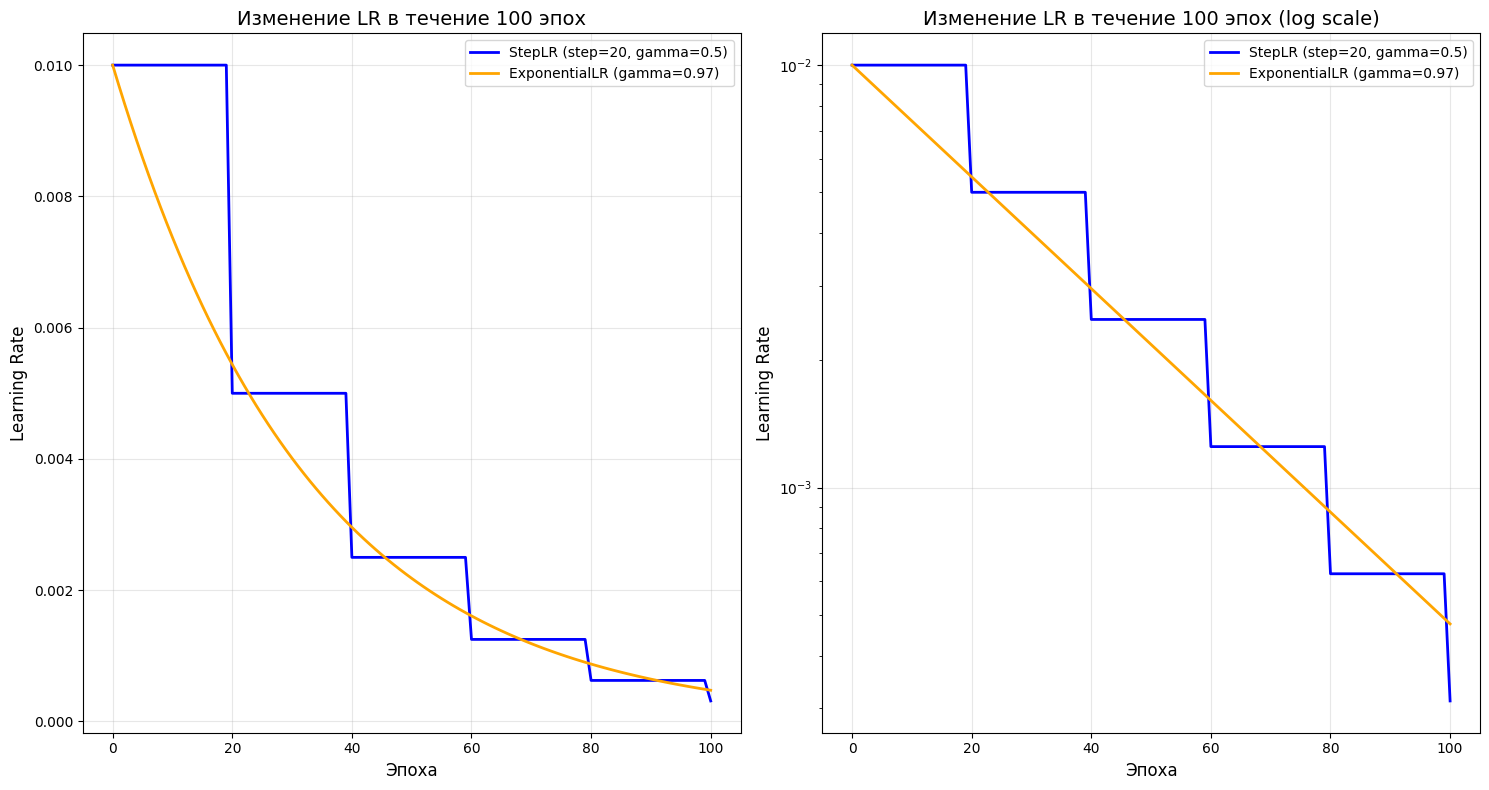

In [9]:
if __name__ == "__main__":
    experiments, X, y = run_experiment()
    visualize_all_results(experiments, X, y)
    visualize_lr_detailed()

# Выводы

## Введение

В данной лабораторной работе было реализовано три оптимизатора (Nesterov, Adam, RMSProp) и два шедулера скорости обучения (StepLR и ExponentialLR). Цель работы — сравнить эффективность различных комбинаций оптимизаторов и шедулеров на задаче регрессии.

## Исходные данные

Для тестирования были сгенерированы синтетические данные для регрессии, представляющие собой сложную нелинейную зависимость:

```python
y_true = 0.5 * X + 2 * np.sin(X) + 1.5
```

С добавлением нормального шума для имитации реальных данных.

![Исходные данные для регрессии](plots/original_data.png)

Как видно из графика, данные представляют собой синусоидальную функцию с линейным трендом. Такая зависимость достаточно сложна для аппроксимации и хорошо подходит для тестирования различных алгоритмов оптимизации.

## Анализ изменения скорости обучения (Learning Rate)

### Сравнение StepLR и ExponentialLR

![Изменение LR в течение 100 эпох](plots/lr_comparison_detailed.png)

На графике выше хорошо видно принципиальное отличие между двумя шедулерами:

- **StepLR** понижает learning rate ступенчато: каждые 20 эпох значение уменьшается в 2 раза (gamma=0.5). Это создает четкие периоды обучения с постоянной скоростью.
- **ExponentialLR** понижает learning rate плавно, экспоненциально: на каждой эпохе значение умножается на 0.97. Получается более гладкое снижение без резких переходов.

В логарифмическом масштабе (правая часть графика) видно, что оба подхода в конечном итоге приводят к схожему уменьшению learning rate, но характер изменения принципиально разный.

### Изменение LR для разных оптимизаторов

![Изменение скорости обучения с StepLR и ExponentialLR](plots/lr_changes.png)

На этом графике показано изменение скорости обучения для разных оптимизаторов с двумя типами шедулеров:

1. **StepLR** (верхний график):
   - Nesterov с StepLR: начальное значение LR = 0.001
   - Adam с StepLR: начальное значение практически не видно на графике
   - RMSProp с StepLR: начальное значение LR = 0.01

2. **ExponentialLR** (нижний график):
   - Nesterov с ExponentialLR: начальное значение LR = 0.02
   - Adam с ExponentialLR: начальное значение LR = 0.01
   - RMSProp с ExponentialLR: начальное значение LR = 0.01

Важно отметить, что выбор начального значения learning rate значительно влияет на скорость сходимости и стабильность обучения.

## Анализ истории потерь (Loss History)

![История потерь для всех экспериментов](plots/loss_history.png)

График истории потерь (MSE) для всех шести экспериментов в логарифмическом масштабе показывает:

1. **Лучшие результаты** показали Adam и RMSProp с обоими типами шедулеров - они достигли наименьшей ошибки (примерно 0.1) к концу обучения.

2. **Nesterov с StepLR и ExponentialLR**, а также RMSProp с ExponentialLR показали более медленную сходимость и остались на уровне ошибки примерно 0.2-0.3.

3. **Nesterov с ExponentialLR** демонстрировал неустойчивое поведение в первой половине обучения (видны значительные скачки потерь), но после 40-й эпохи произошло резкое улучшение.

4. **Adam с обоими шедулерами** показал наиболее стабильное снижение ошибки без заметных скачков.

## Анализ результатов регрессии

![Результаты регрессии для всех экспериментов](plots/regression_results.png)

Графики показывают, как разные комбинации оптимизатора и шедулера справились с аппроксимацией исходных данных:

1. **Nesterov (с обоими шедулерами)** не смог точно воспроизвести спад функции при x > 8, давая почти линейное предсказание в этой области.

2. **Adam и RMSProp (с обоими шедулерами)** намного точнее воспроизвели форму исходных данных, включая падение значений при x > 8.

3. Разница между StepLR и ExponentialLR для одного и того же оптимизатора не столь существенна в конечном результате регрессии, хотя есть небольшие различия в характере аппроксимации.

## Общие выводы

1. **Adam показал себя наиболее эффективным оптимизатором** для данной задачи регрессии, обеспечивая стабильную сходимость и точную аппроксимацию нелинейной функции.

2. **RMSProp по эффективности близок к Adam**, что согласуется с теоретическими ожиданиями, так как оба оптимизатора используют адаптивные скорости обучения для разных параметров.

3. **Nesterov показал худшие результаты**, не сумев точно воспроизвести сложную форму зависимости, особенно в области больших значений x. Это может быть связано с тем, что метод Нестерова более чувствителен к выбору гиперпараметров.

4. **Выбор шедулера (StepLR vs ExponentialLR) оказался менее значимым фактором**, чем выбор оптимизатора. Однако ExponentialLR обеспечивает более плавное изменение learning rate, что может быть предпочтительнее для некоторых задач.

5. **Начальное значение LR критично влияет на сходимость** - для Nesterov с ExponentialLR высокое начальное значение (0.02) привело к нестабильности в начале обучения.

## Заключение

Данные эксперименты подтверждают теоретические преимущества адаптивных оптимизаторов (Adam, RMSProp) над более простыми методами оптимизации первого порядка с моментом (Nesterov) для сложных нелинейных задач регрессии.

Шедулеры скорости обучения выполняют важную функцию постепенного уменьшения learning rate, что помогает модели сначала быстро приближаться к минимуму функции потерь, а затем более точно настраиваться. При этом выбор между ступенчатым (StepLR) и плавным (ExponentialLR) уменьшением зависит от конкретной задачи и предпочтений исследователя.

Полученные результаты также указывают на важность правильного выбора начальной скорости обучения, которая должна быть достаточно большой для быстрой сходимости, но не настолько большой, чтобы вызывать нестабильность обучения.
